# Housing price modeling

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the five major metropolitan areas in U.S. is implemented. The corresponding five major metropolitan areas are New York, Chicago, Los Angeles, Philadelphia, and Washington. The data of this project is HouseTS dataset which can be found from.

## Data onboarding

Fetch the data from the kaggle API (saved as a local file)

In [ ]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

In [12]:
# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("shengkunwang/housets-dataset")
data_path = os.path.join(data_dir, "HouseTS.csv");

Using Colab cache for faster access to the 'housets-dataset' dataset.


Load the data from the local file

In [11]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(884092, 39)
         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31            46550.0           217450.0    31.813674   
1  2012-04-30            61870.0           245000.0    40.723982   
2  2012-05-31           125500.0           217450.0    63.913043   
3  2012-06-30           153000.0           189900.0    81.598080   
4  2012-07-31           165500.0           154000.0    81.598080   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0        110.183666        14.0           23.0          44.0       64.0   
1        130.528256        22.0           29.0          56.0       69.0   
2        119.919216        24.0           40.0          63.0       60.0   
3        105.617353        34.0           46.0          50.0       57.0   
4         83.921175        39.0           49.0          42.0       50.0   

   median_dom  ...  Total Housing Units  Median Rent  Median Home Value  \
0        59.5  ...               2677.0        710.0

---

## Data visualization and exploratory analysis

---

## Time-series decomposition analysis

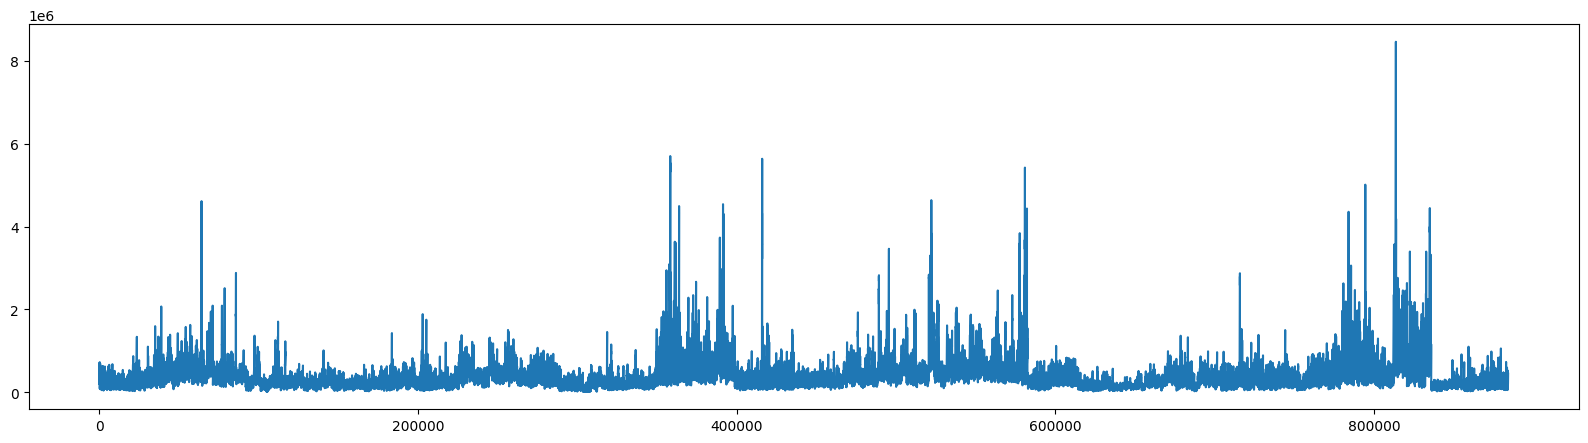

In [15]:
plt.figure(figsize=(20,5))
plt.plot(data["price"])
plt.show()

---

## Autocorrelation analysis

---

## Partitioning the time-series data